In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
pd.set_option('display.max_columns', 50)

# Первичный анализ данных

https://www.kaggle.com/harlfoxem/housesalesprediction

**Данные являются официальной статистикой продаж домов в США в округе Кинг, который включает в себя Сиэтл. Сам датасет содержит информацию по 21613 сделкам за 2014 - 2015 годы.**

**Прокомментируем предоставленные в датасете признаки:**

Id сделки, Zipcode, lat, long нам не потребуются, выбросим эти столбцы в дальнейшем

Дата в формате строки, необходимо будет преобразовать для более удобной работы

Из категориальных переменных только waterfront, указывает на факт расположения дома на берегу водоема

Condition, View и Grade - оценки жилья независимым экспертом

Год постройки и реставрации, если она проводилась, иначе значение 0

Также различные параметры жилья, это количество этажей(floors), число спален(bedrooms), несколько площадей, относящихся как к дому, так и к участку возле него.

In [2]:
with open('./kc_house_data.csv') as f:
    df = pd.read_csv(f)

In [343]:
df.shape

(21613, 21)

In [4]:
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**Цель проекта - исследование рынка жилья США на примере данных из округа Кинг. Помимо этого будут проверены статистические гипотезы и сделано предсказание временного ряда продаж.**

# Предобработка данных

In [3]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

**Видим, что "нанов" нет, это хорошо.**

**Выбросим столбцы "id" и "zipcode", "lat", "long", они точно не пригодятся.**

In [3]:
df.drop(['id', 'zipcode', 'lat', 'long'], axis=1, inplace=True)

**Далее добавим еще столбцы для более удобного ориентирования по датам.**

In [4]:
df['date'] = pd.to_datetime(df.date,format='%Y%m%d %H') 
df.sort_values('date', inplace=True)

In [5]:
df.index  = df.date
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['week'] = df.index.week

**Посмотрим на гистограмму количества купленных домов по месяцам за период сбора статистики.**

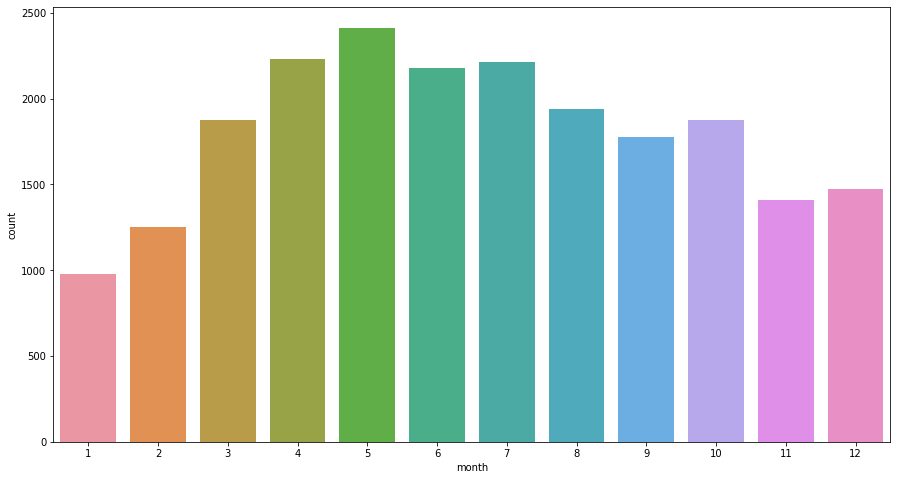

In [13]:
plt.figure(figsize=(15,8))
sns.countplot(df['month'])

**Видим много продаж в мае, исследуем этот факт более пристальным образом.**

In [368]:
df[df.year == 2014]['month'].unique(), df[df.year == 2015]['month'].unique()

(array([ 5,  6,  7,  8,  9, 10, 11, 12]), array([1, 2, 3, 4, 5]))

In [369]:
df[df.month == 5]['year'].unique()

array([2014, 2015])

**Оказывается, в мае накладываются данные за два года, это мы и увидели на гистограмме. Тогда для удобства работы с данными будем ориентироваться не на даты, а на количество дней/недель, прошедших с начала сбора статистики.**

In [6]:
df['w_passed'] = (df['year'] - 2014) * 52 + df['week'] - 18

In [371]:
np.sort(df['w_passed'].unique())

array([-17,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56])

**Появились отрицательные значения, разберемся, с чем это связано.**

In [351]:
print(df[df.w_passed == -17]['date'].unique())

['2014-12-29T00:00:00.000000000' '2014-12-30T00:00:00.000000000'
 '2014-12-31T00:00:00.000000000']


**Оказывается, что -17 получилось для данных за неделю, которая началась в 2014г., а закончилась в 2015г. Исправим это, присвоив корректное значение, то есть первой недели 2015г.**

In [7]:
df['w_passed'].replace(
    to_replace=-17,
    value=35,
    inplace=True
)

In [8]:
df['d_passed'] = df['date'] - df.iloc[0]['date']
df['d_passed'] = pd.to_numeric(df['d_passed'].dt.days, downcast='integer')

In [30]:
df.query('month == 5 and year == 2014')['day'].unique(), df.query('month == 5 and year == 2015')['day'].unique()

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 24, 27]))

**Также видно, что в первый и последний месяцы данных статистика собрана за все дни, а не до середины, как могло бы случиться, это хорошо.**

# Теперь перейдем к визуальному анализу данных

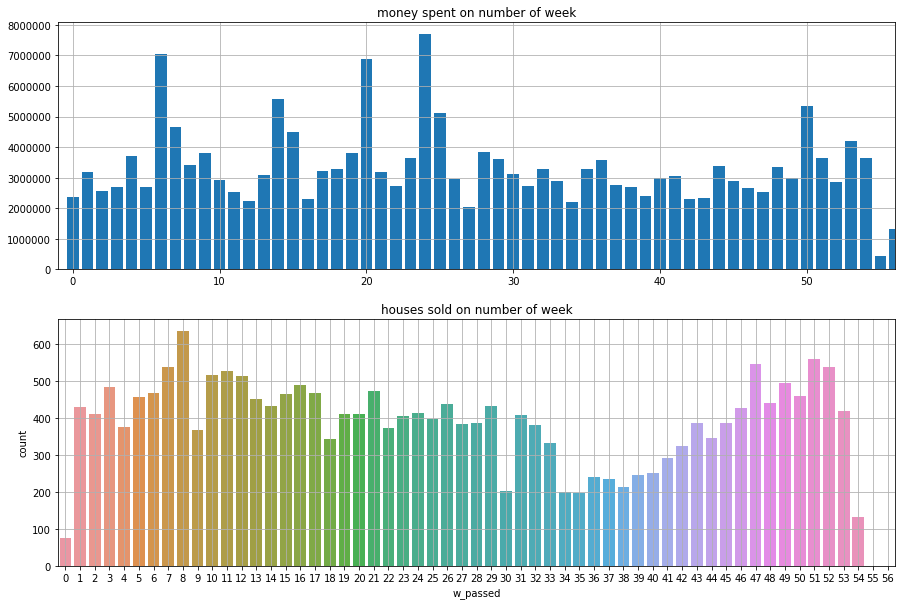

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1.bar(df['w_passed'], df['price'])
ax1.set_xlim(-1, 56)
ax1.grid()
ax1.set_title('money spent on number of week')
ax2 = fig.add_subplot(212)
sns.countplot(x = df['w_passed'])
ax2.set_title('houses sold on number of week')
ax2.grid()
plt.show()

**Видно, что суммарная стоимость проданных домов имеет малую амплитуду колебаний, однако, есть недели, выбивающиеся из общей картины. Например, 20-я и 24-я. Сравним статистику за эти недели с 30-й, когда аномалий не наблюдалось.**

In [69]:
df[df.w_passed == 20]['price'].describe()

count    4.100000e+02
mean     5.230533e+05
std      4.354300e+05
min      8.500000e+04
25%      3.216250e+05
50%      4.475000e+05
75%      6.149875e+05
max      6.885000e+06
Name: price, dtype: float64

In [70]:
df[df.w_passed == 24]['price'].describe()

count    4.120000e+02
mean     5.618704e+05
std      5.060422e+05
min      8.900000e+04
25%      3.199800e+05
50%      4.517500e+05
75%      6.662375e+05
max      7.700000e+06
Name: price, dtype: float64

In [71]:
df[df.w_passed == 30]['price'].describe()

count    2.030000e+02
mean     5.577131e+05
std      4.125004e+05
min      9.000000e+04
25%      3.249750e+05
50%      4.449500e+05
75%      6.550000e+05
max      3.120000e+06
Name: price, dtype: float64

**Видно, что средняя цена проданных домов не превосходит 30-ю неделю, а количество, наоборот - в 2 раза больше. Отсюда заключаем, что резкие скачки на графике связаны не с продажей очень дорогих объектов, а именно с особенностями рынка и большим спросом.**

In [352]:
for week in np.sort(df['w_passed'].unique()):
    print(f'week:{week}, month:{df[df.w_passed == week].month[0]}, year:{df[df.w_passed == week].year[0]}')

week:-17, month:12, year:2014
week:0, month:5, year:2014
week:1, month:5, year:2014
week:2, month:5, year:2014
week:3, month:5, year:2014
week:4, month:5, year:2014
week:5, month:6, year:2014
week:6, month:6, year:2014
week:7, month:6, year:2014
week:8, month:6, year:2014
week:9, month:6, year:2014
week:10, month:7, year:2014
week:11, month:7, year:2014
week:12, month:7, year:2014
week:13, month:7, year:2014
week:14, month:8, year:2014
week:15, month:8, year:2014
week:16, month:8, year:2014
week:17, month:8, year:2014
week:18, month:9, year:2014
week:19, month:9, year:2014
week:20, month:9, year:2014
week:21, month:9, year:2014
week:22, month:9, year:2014
week:23, month:10, year:2014
week:24, month:10, year:2014
week:25, month:10, year:2014
week:26, month:10, year:2014
week:27, month:11, year:2014
week:28, month:11, year:2014
week:29, month:11, year:2014
week:30, month:11, year:2014
week:31, month:12, year:2014
week:32, month:12, year:2014
week:33, month:12, year:2014
week:34, month:12

**Также можем заметить что в 0-ю и 54-ю, 55-ю, 56-ю недели домов было продано крайне мало, это соответствует маю в 2014г. и 2015г. годах. На первый взгляд может показаться, что просто не хватает данных, но мы проверили ранее, что сделки в те месяцы были практически во все дни. Но и сделать вывод о такой особенности поведения рынка в этот месяц года не можем, так как нет полных данных за несколько лет. Просто отметим этот факт малого количества сделок в мае.**

**Далее рассмотрим гистограмму проданных домов в зависимости от года их постройки. Часть домов первой половины 20-го века были снесены, таким образом, мы не получим информации об абсолютном значении количества построенных домов, к примеру в 1930-е, тем не менее корректно будет сравнивать соседние несколько лет из первой половины прошлого столетия, что даст возможность проследить динамику объемов строительства.**

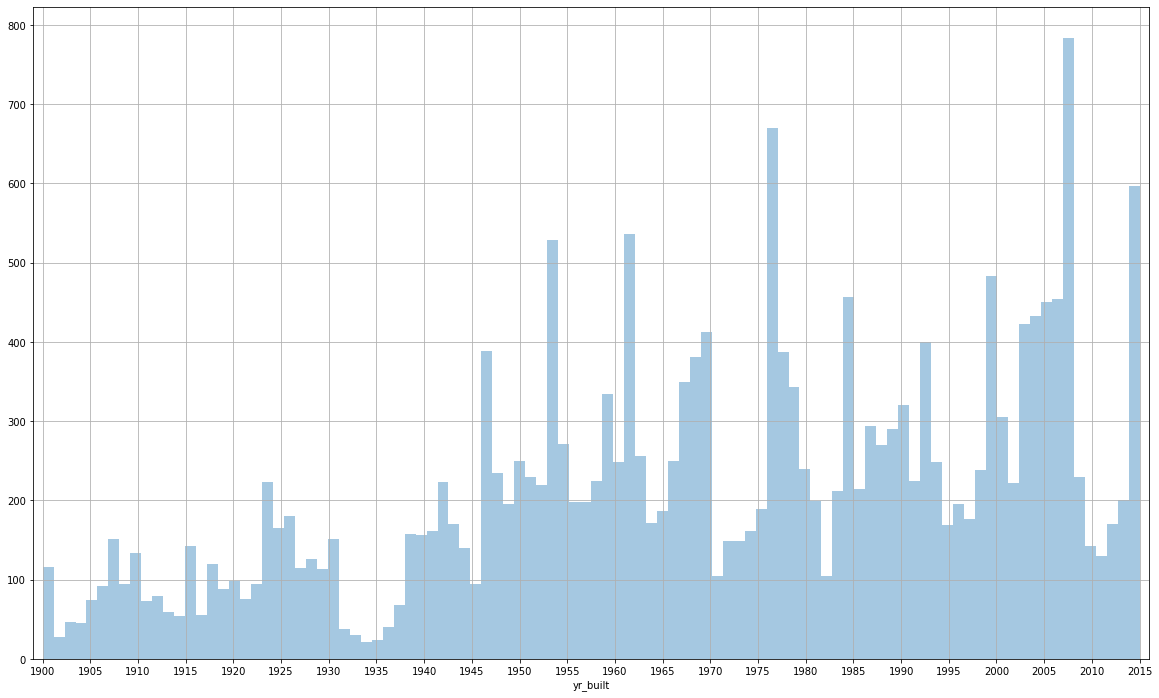

In [30]:
plt.figure(figsize=(20,12))
h = sns.distplot(df['yr_built'], bins=100, kde=False)
plt.grid()
h.set(xticks=range(1900, 2016, 5), xlim=(1899, 2016))
plt.show()

**Известный факт, что при неблагоприятной экономической обстановке в стране девелоперские компании страдают очень сильно. Это прослеживается на графике. 1930-е года - Великая депрессия в США. Резкие падения с 1955 по 1975 годы могут быть связаны с экономическими последствиями продолжавшейся войны во Вьетнаме. Но не будем забывать про кризис, начавшийся в 1973 году, который был вызван действиями членов ОПЕК. Начало 2000-х - это кризис "доткомов", а также теракт 11 сентября, имевший также большие экономические последствия. Далее мы видим последствия кризиса 2007 года, в котором жилищный сектор пострадал очень сильно не только из-за падения доходов населения, безработицы, но и ранее бесконтрольно выдававшихся ипотечных кредитов, оказавшихся впоследствии невозвращенными. Остальные резкие скачки, вероятно, также имеют обоснование с точки зрения экономических событий в стране, но искать причины придется несколько глубже, например, отслеживать субсидии государства девелоперам и прочие тонкости.**

**Теперь взглянем на хитмап корреляций между столбцами.**

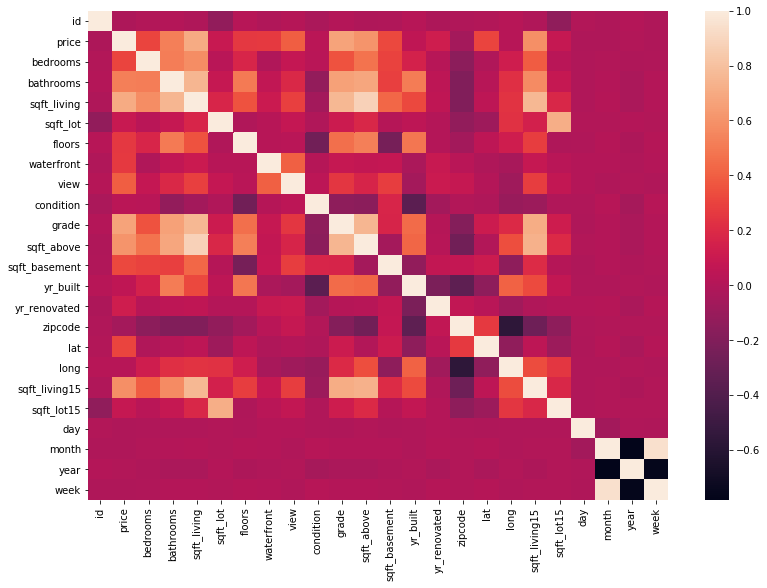

In [120]:
fig = plt.figure(figsize=(13,9))
sns.heatmap(df.corr())

**Видно, что цена довольно сильно коррелирует с оценкой дома, а также с различными площадями, в том числе с площадью ванной комнаты.**

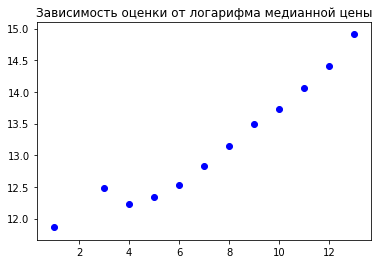

In [354]:
plt.figure(figsize=(6,4))
for i in df['grade'].unique():
    plt.scatter(x=i, y=np.log(df[df.grade == i]['price'].median()), color='blue')
plt.title('Зависимость оценки от логарифма медианной цены')
plt.show()

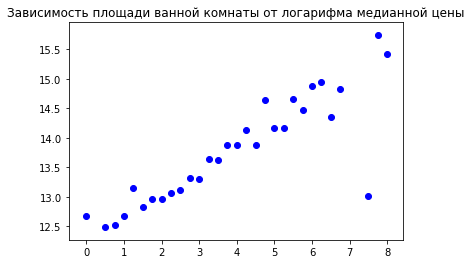

In [284]:
plt.figure(figsize=(6,4))
for i in df['bathrooms'].unique():
    plt.scatter(x=i, y=np.log(df[df.bathrooms == i]['price'].median()), color='blue')
plt.title('Зависимость площади ванной комнаты от логарифма медианной цены')
plt.show()

In [88]:
df['sqft_living'].describe()

count    21613.000000
mean      1788.390691
std        828.090978
min        290.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

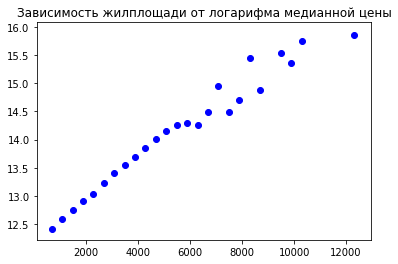

In [282]:
plt.figure(figsize=(6,4))
x_prev = 0
for i in (range(290, 13541, 400)):
    tmp = df.query(f'sqft_living < {i} and sqft_living >= {x_prev}')
    plt.scatter(x=i, y=np.log(tmp['price'].median()), color='blue')
    x_prev = i
plt.title('Зависимость жилплощади от логарифма медианной цены')
plt.show()

In [89]:
df['sqft_above'].describe()

count    21613.000000
mean      1788.390691
std        828.090978
min        290.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

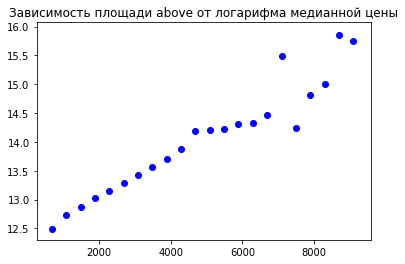

In [283]:
plt.figure(figsize=(6,4))
x_prev = 0
for i in (range(290, 9410, 400)):
    tmp = df.query(f'sqft_above < {i} and sqft_above >= {x_prev}')
    plt.scatter(x=i, y=np.log(tmp['price'].median()), color='blue')
    x_prev = i
plt.title('Зависимость площади above от логарифма медианной цены')
plt.show()

In [91]:
df['sqft_living15'].describe()

count    21613.000000
mean      1986.552492
std        685.391304
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

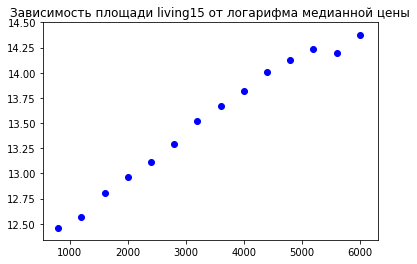

In [280]:
plt.figure(figsize=(6,4))
x_prev = 0
for i in (range(399, 6210, 400)):
    tmp = df.query(f'sqft_living15 < {i} and sqft_living15 >= {x_prev}')
    plt.scatter(x=i, y=np.log(tmp['price'].median()), color='blue')
    x_prev = i
plt.title('Зависимость площади living15 от логарифма медианной цены')
plt.show()

**На всех графиках мы видим приближенно степенную зависимость. Это указывает на то, что после взятия логарифма от этих столбцов, линейной регрессией можно будет достаточно точно предсказать цену дома по его характеристикам, однако цель данного проекта не в этом.**

**Рассмотрим временной ряд суммарной стоимости проданного жилья за каждый день ведения статистики, исключив первый и последний месяцы, т.к. заметили в них аномалии, которые могут быть связаны с недостоверными данными.**

In [148]:
df1['z_data'] = (df1['money'] - df1.money.rolling(window=7).mean())
df1['zp_data'] = df1['z_data'] - df1['z_data'].shift(7)
def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df1.days[30:-30], df1.money[30:-30], label='raw data')
    ax[0].plot(df1.days[30:-30], df1.money.rolling(window=7).mean()[30:-30], label="rolling mean");
    ax[0].legend()
    ax[1].plot(df1.days[30:-30], df1.z_data[30:-30], label="de-trended data")
    ax[1].plot(df1.days[30:-30], df1.z_data.rolling(window=7).mean()[30:-30], label="rolling mean");
    ax[1].legend()
    ax[2].plot(df1.days[30:-30], df1.zp_data[30:-30], label="7 lag differenced de-trended data")
    ax[2].plot(df1.days[30:-30], df1.zp_data.rolling(window=7).mean()[30:-30], label="rolling mean");
    ax[2].legend()
    plt.tight_layout()
    fig.autofmt_xdate()

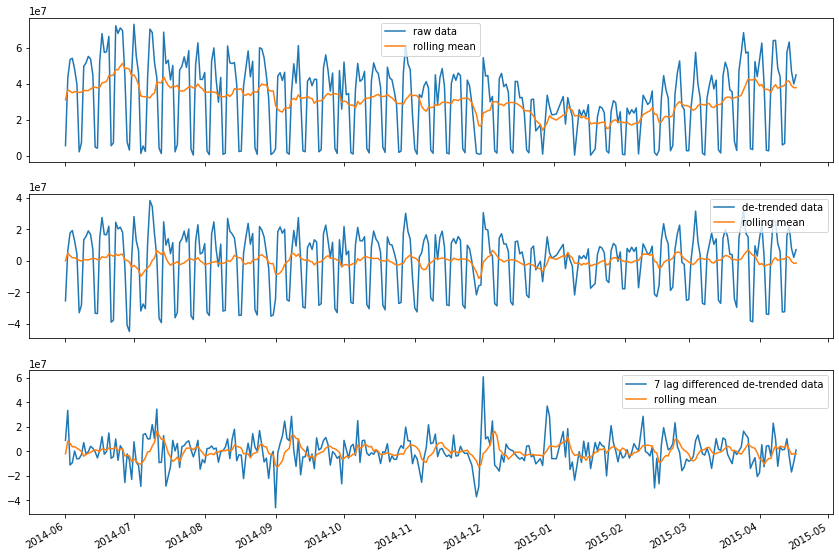

In [149]:
plot_rolling(df)

**На последнем графике где из значения детрендированного второго графика в каждой точке вычиталось значение неделю назад. Видно маленькую амплитуду колебаний, что наталкивает на мысль о недельной сезонности. Проверим это, рассмотрев разложение исходного временного ряда на компоненты.**

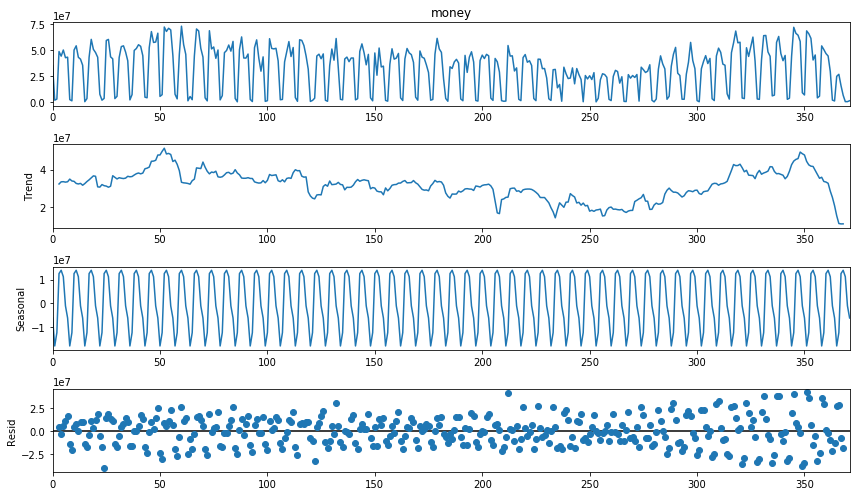

In [150]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(df1.money, model='additive',period= 7)
result.plot()
plt.show()

Левое значение - дата одного из локальных минимумов, второе - дата глобального спада.

In [378]:
df[df.d_passed == 50]['date'].iloc[0], df[df.d_passed == 245]['date'].iloc[0]

(Timestamp('2014-06-21 00:00:00'), Timestamp('2015-01-02 00:00:00'))

**Видим совершенно четкую недельную сезонность. Причем минимумы соответствуют выходным, что обосновывается нерабочими днями в организациях, обеспечивающих нотариальное и юридическое сопровождение сделок, а также в банках. После этого резкое увеличение продаж в начале недели и спад к концу. Можно предположить, что показы домов риэлторами производятся в основном в выходные, когда свободны клиенты и собственники жилья, но невозможно заключить сделки. Затем, с началом рабочей недели, люди, определившись с покупками, торопятся их осуществлять. Об этом свидетельствует резкий рост количества сделок после локальных минимумов(выходных) на самом верхнем графике, представленном без изменений, затем идет падение, но уже менее стремительное, чем был рост, т.к. основная масса людей, кто определились с покупкой в выходные, уже сделали их, но не все.**

**Также очевиден глобальный спад в период новогодних праздников и начала года в целом. Люди отдыхают, рынок практически не работает, что логично.**

**Далее посмотрим, как влияет факт расположения дома на берегу и вид из окна на его цену.**

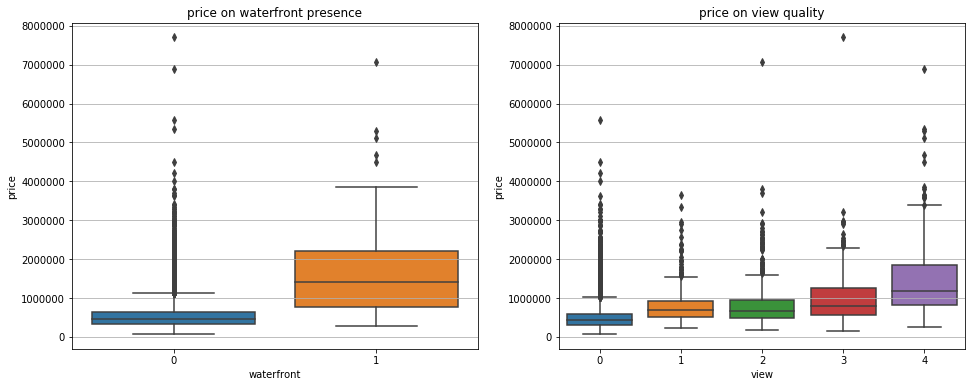

In [151]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('price on waterfront presence')
ax2.set_title('price on view quality')
ax1.grid()
ax2.grid()
sns.boxplot(x=df['waterfront'], y=df['price'], ax=ax1)
sns.boxplot(x=df['view'], y=df['price'], ax=ax2)
plt.show()

**Видим увеличение медианной цены по мере улучшения вида и при расположении дома на берегу, что очень логично.**

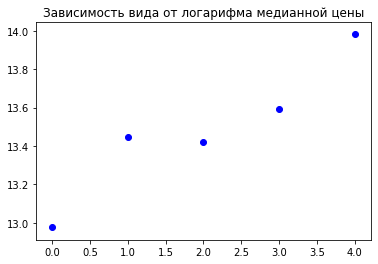

In [278]:
plt.figure(figsize=(6,4))
for i in df['view'].unique():
    plt.scatter(x=i, y=np.log(df[df.view == i]['price'].median()), color='blue')
plt.title('Зависимость вида от логарифма медианной цены')
plt.show()

**Зависимость в целом является степенной, однако значение view == 1 явно выбивается из общей картины. На количество выбросов на boxplot смотреть не стоит, потому что домов с view == 1 и waterfront == 0 гораздо больше чем всех остальных.**

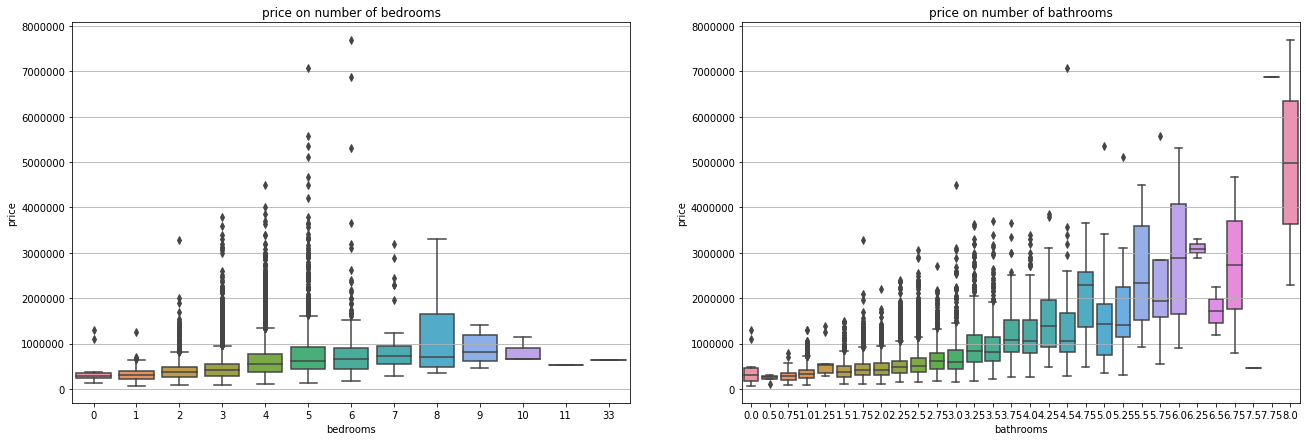

In [267]:
fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid()
ax2.grid()
ax1.set_title('price on number of bedrooms')
ax2.set_title('price on number of bathrooms')
sns.boxplot( x=df["bedrooms"], y=df["price"], ax=ax1)
sns.boxplot( x=df["bathrooms"], y=df["price"], ax=ax2)

**Изобразим завимость цены от числа спален и ванных комнат. Целые значения количества ванных комнат соответствуют объединенным душевой и туалету, а дробные - когда в комнате расположено что-то одно.**

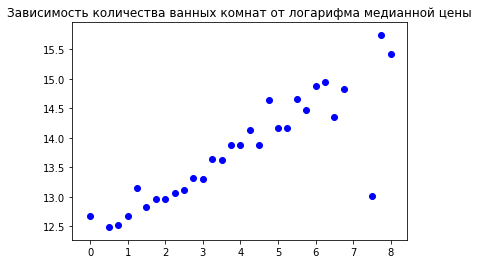

In [276]:
plt.figure(figsize=(6,4))
for i in df['bathrooms'].unique():
    plt.scatter(x=i, y=np.log(df[df.bathrooms == i]['price'].median()), color='blue')
plt.title('Зависимость количества ванных комнат от логарифма медианной цены')
plt.show()

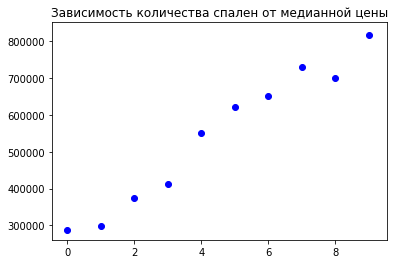

In [277]:
plt.figure(figsize=(6,4))
for i in np.sort(df['bedrooms'].unique())[:-3]:
    plt.scatter(x=i, y=df[df.bedrooms == i]['price'].median(), color='blue')
plt.title('Зависимость количества спален от медианной цены')
plt.show()

**Убрав три самых больших значения, являющихся выбросами, мы имеем линейную зависимость.**

**Таким образом, цена от количества ванных комнат имеет степенную зависимость, а от количества спален - линейную, что достаточно необычно.**

# Предсказание временного ряда

**Предсказывать будем суммарную стоимость проданных домов за некоторый промежуток времени в дневном масштабе. Но сначала сделаем еще один датафрейм и поместим туда данные после подсчета в функции денег за каждый день.**

In [21]:
def get_data(df):
    days = []
    money = []
    count = []
    for i in df.date.unique():
        days.append(i)
        money.append(df[df.index == i]['price'].sum())
    return days, money

In [22]:
days, money = get_data(df)

In [23]:
df1 = pd.DataFrame()
df1['days'] = days
df1['money'] = money

In [24]:
train = df1.iloc[:-50]
test = df1.iloc[-50:-30]
num = 20
train.index = pd.to_datetime(train.days)
test.index = pd.to_datetime(test.days)

**В разделе визуального анализа данных мы уже обнаружили четкую недельную сезонность. Сейчас нам это очень поможет. Добавим этот параметр в модель предсказания.**

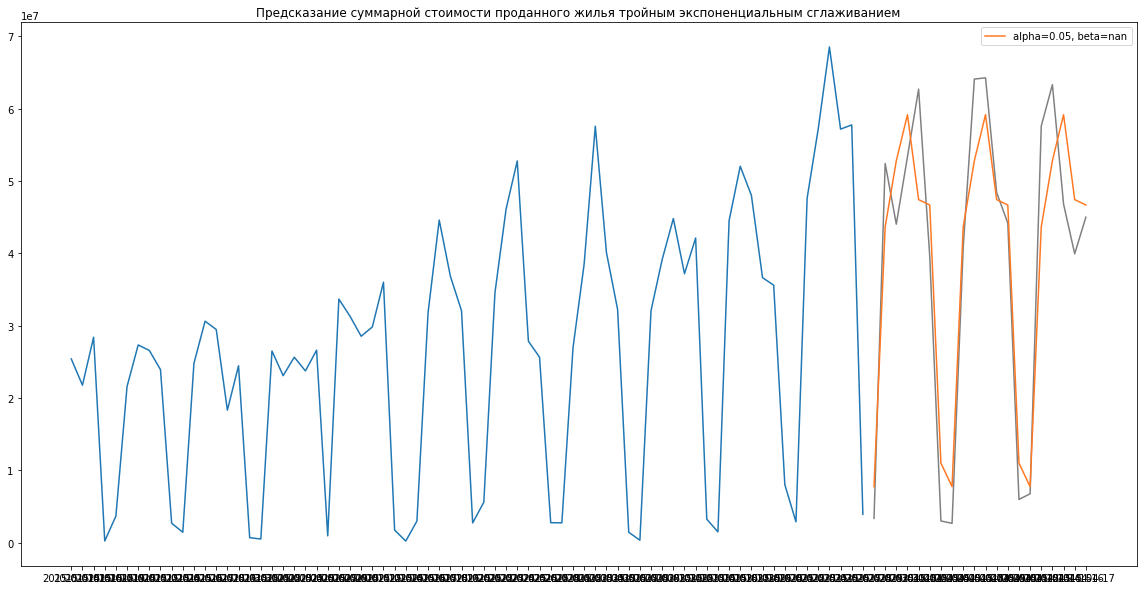

In [25]:
model = ExponentialSmoothing(np.asarray(train['money']), damped=False, seasonal='add', seasonal_periods=7)
fit1 = model.fit(optimized=True)
pred1 = fit1.forecast(num)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(train.index[250:].astype(str), train.money[250:])
ax.plot(test.index.astype(str), test.money, color="gray")
ax.plot(test.index.astype(str), pred1, label="alpha="+str(fit1.params['smoothing_level'])[:4]+\
        ", beta="+str(fit1.params['smoothing_slope'])[:4], color='#ff7823')
plt.title("Предсказание суммарной стоимости проданного жилья тройным экспоненциальным сглаживанием")
plt.legend();

**По пографку видно, что предсказанная зависимость практически совпадает с фактическими данными за этот период.**

# Проверка статистических гипотез

In [110]:
df['yr_built'].median()

1975.0

**1975 год - медиана по суммарному количеству продаж.**

# Первая гипотеза

# Проверим, равны ли средние жилые площади у домов, построенных до и после 1975 года

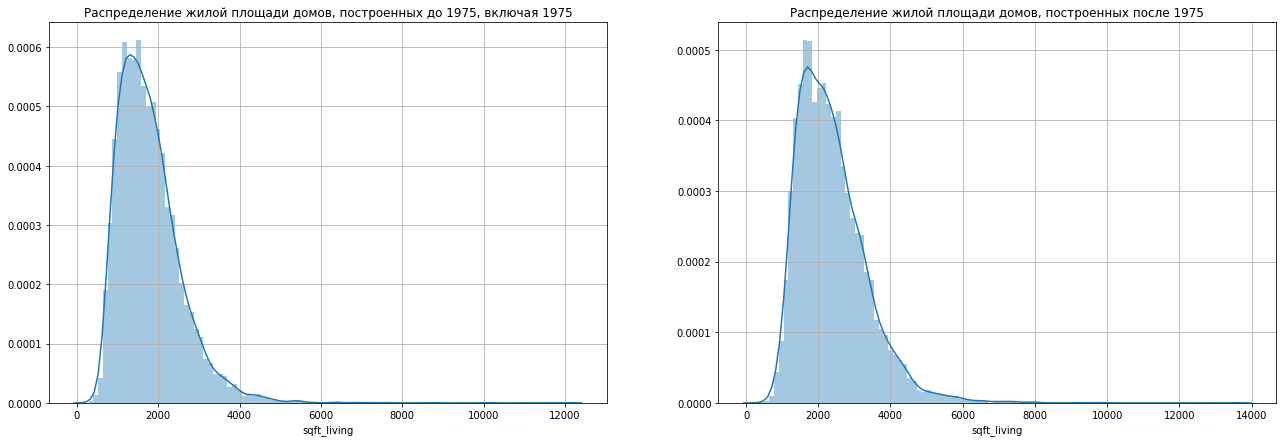

In [291]:
fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid()
ax2.grid()
ax1.set_title('Распределение жилой площади домов, построенных до 1975, включая 1975')
ax2.set_title('Распределение жилой площади домов, построенных после 1975')
sns.distplot(df[df.yr_built <= 1975]['sqft_living'], bins=100, ax=ax1)
sns.distplot(df[df.yr_built > 1975]['sqft_living'], bins=100, ax=ax2)

**Похоже на логнормальное. Построим то же самое от логарифма площади.**

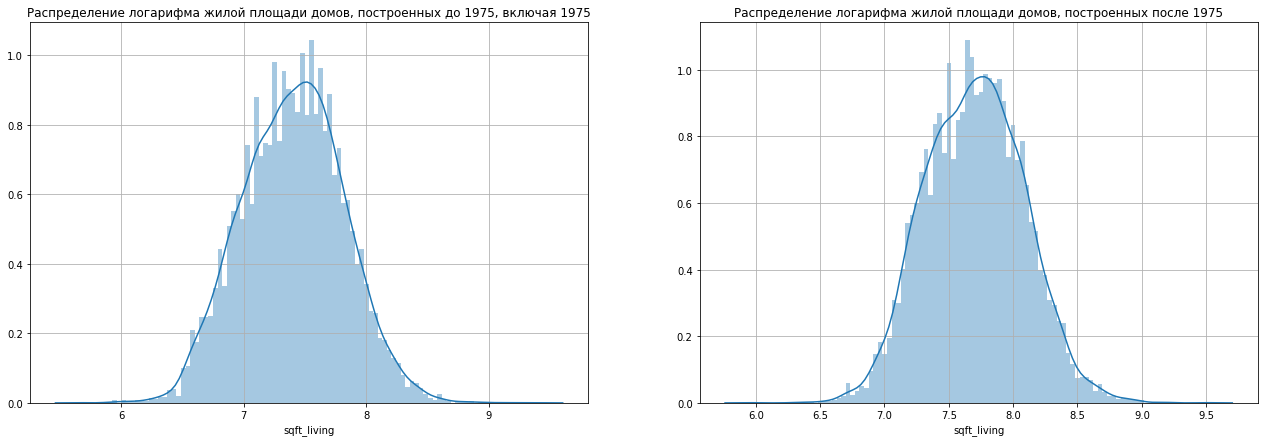

In [292]:
fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid()
ax2.grid()
ax1.set_title('Распределение логарифма жилой площади домов, построенных до 1975, включая 1975')
ax2.set_title('Распределение логарифма жилой площади домов, построенных после 1975')
sns.distplot(np.log(df[df.yr_built <= 1975]['sqft_living']), bins=100, ax=ax1)
sns.distplot(np.log(df[df.yr_built > 1975]['sqft_living']), bins=100, ax=ax2)

**Похоже на нормальное, но проверим это с помощью Q-Q plot.**

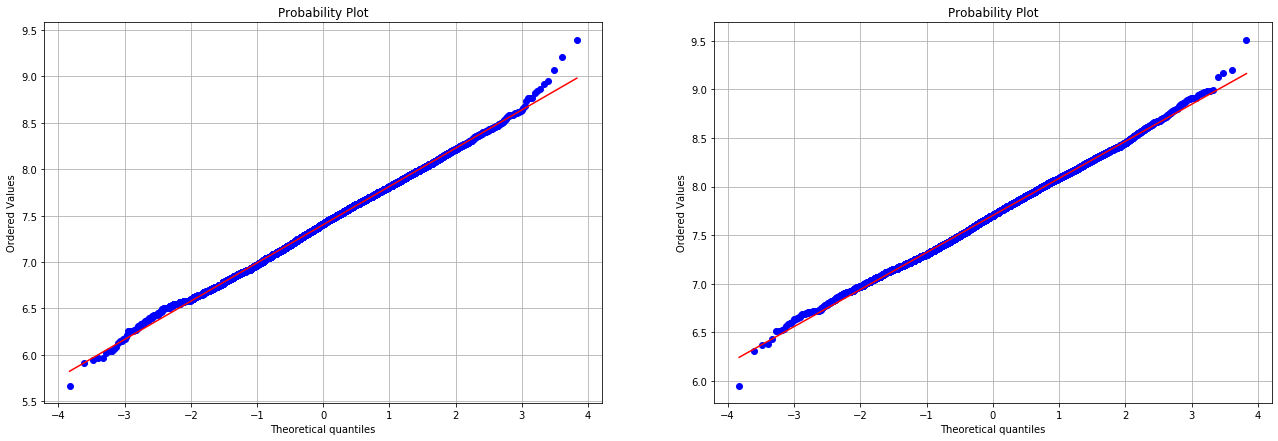

In [381]:
fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid()
ax2.grid()
stats.probplot(np.sort(np.log(df[df.yr_built <= 1975]['sqft_living'])), dist='norm', plot=ax1)
stats.probplot(np.log(df[df.yr_built > 1975]['sqft_living']), dist='norm', plot=ax2)
plt.show()

**Видно, что эти распределения можно приближенно считать нормальными, хотя на концах отклонения возникают в обоих случаях.**

**Проверим при помощи т-критерия для независимых выборок равенство средних значений логарифмов площади, но из равенств/отличий логарифмов будет следовать то же самое и для самих средних площадей.**

Гипотеза Н0 - средние равны.

Гипотеза Н1 - не равны.

In [125]:
rvs1 = np.log2(df[df.yr_built > 1975]['sqft_living'])
rvs2 = np.log2(df[df.yr_built <= 1975]['sqft_living'])
stats.ttest_ind(rvs1,rvs2)

Ttest_indResult(statistic=55.4098133181234, pvalue=0.0)

**Нулевая гипотеза статистически незначима, соотетственно, жилые площади отличаются.**

# Вторая гипотеза. 

# Дома, построенные в 1900-м году дороже новых, построенных в 2015-м. Проверим эту гипотезу при помощи критерия Манна-Уитни.

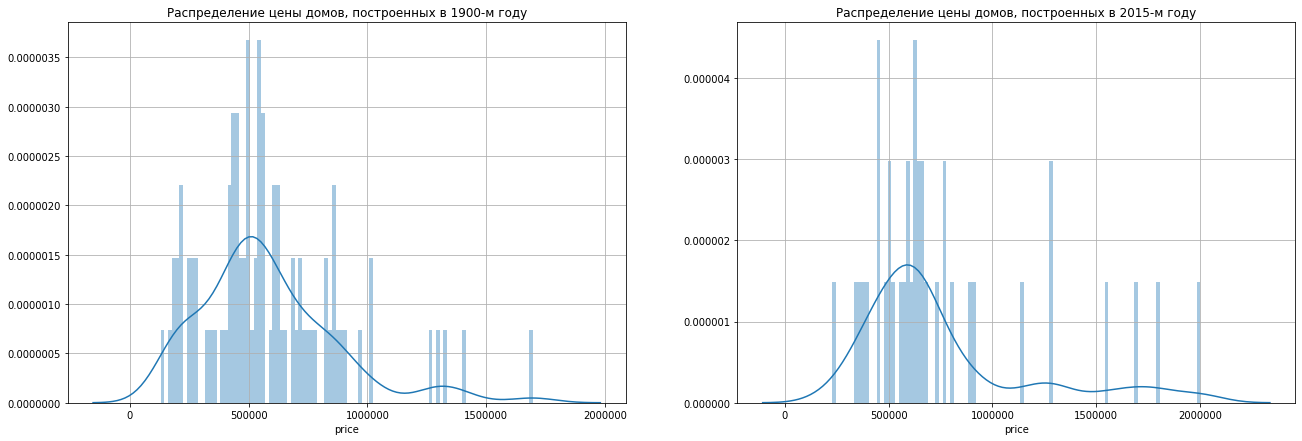

In [12]:
fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid()
ax2.grid()
ax1.set_title('Распределение цены домов, построенных в 1900-м году')
ax2.set_title('Распределение цены домов, построенных в 2015-м году')
sns.distplot(df[df.yr_built == 1900]['price'], bins=100, ax=ax1)
sns.distplot(df[df.yr_built == 2015]['price'], bins=100, ax=ax2)

Н0 - в 2015 дешевле

Н1 - в 2015 дороже

In [340]:
stats.mannwhitneyu(df[df.yr_built == 1900]['price'], df[df.yr_built == 2015]['price'], alternative = 'less')

MannwhitneyuResult(statistic=1211.0, pvalue=0.008899692731701)

**Нулевая гипотеза оказалась статистически незначимой, новые дома дороже.**

# Выводы:

**1) Обнаружены степенные и линейные зависимости цены от признаков, что дает представление об особенностях ценообразования жилья.**

**2) Подтверждено утверждение о зависимости рынка жилья от экономической ситуации в стране.**

**3) Исследовано поведение временного ряда продаж домов, выдвинуты предположения, объясняющие особенности рынка, в частности сезонность и глобальный спад в начале года. Также сделано предсказание этого временного ряда.**

**4) Были опровергнуты две гипотезы: 1) Средние жилые площади у домов, построенных до и после 1975г. равны. Несостоятельность этой гипотезы говорит о том, что люди после 1975г. способны купить более дорогое жилье. Уровень жизни и доходы росли быстрее скорректированной на инфляцию стоимости жилья. Также на результат оказала влияние растущая доступность кредитов в стране. Государство придерживается политики дешевых денег, снижая ключевую ставку до минимальных значений, что в купе со средней годовой инфляцией около 2% дает людям возможность жить в более просторных домах. 2) Дома, построенные в 1900-м году дороже новостроек. Несостоятельность этой гипотезы говорит нам факт, не требующий объяснения. Старые дома, построенные в исторических кварталах, стоят дешевле современных и высокотехнологичных, построенных в более новых и удобных по расположению районах городов.**
        